In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 15,15
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm ,tnrange

In [2]:
train = pd.read_csv("train_PDjVQMB.csv")

print(train.shape)

train.head()

(6650, 11)


,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [3]:
test = pd.read_csv("testcheck.csv")

print(test.shape)

test.head()

(2851, 11)


,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,55480787,50,Female,More than 15L,1008636.39,2,1,2,1,Average,1
1,9aededf2,36,Male,5L - 10L,341460.72,2,0,2,1,Average,0
2,a5034a09,25,Female,10L - 15L,439460.10,0,0,2,1,Good,0
3,b3256702,41,Male,Less than 5L,28581.93,0,1,2,1,Poor,0
4,dc28adb5,48,Male,More than 15L,1104540.03,2,1,3+,0,Good,0


In [4]:
train.describe()

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn
count,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000
mean,41.130226,8.045954e+05,2.250226,0.515789,0.664361,0.231128
std,9.685747,5.157549e+05,1.458795,0.499788,0.472249,0.421586
min,21.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000
25%,34.000000,3.922642e+05,1.000000,0.000000,0.000000,0.000000
50%,40.000000,7.649386e+05,2.000000,1.000000,1.000000,0.000000
75%,47.000000,1.147124e+06,3.000000,1.000000,1.000000,0.000000
max,72.000000,2.436616e+06,5.000000,1.000000,1.000000,1.000000


# EDA (Exploratory data analysis)

<AxesSubplot:xlabel='Credit_Category', ylabel='Age'>

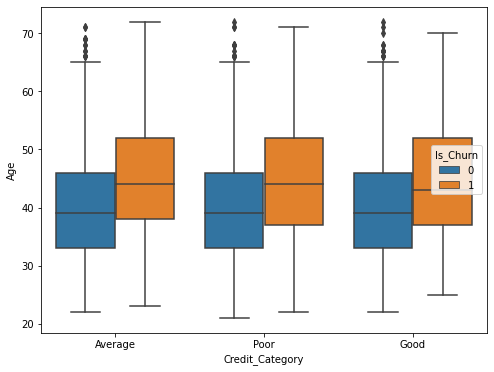

In [5]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Credit_Category',y='Age',hue='Is_Churn',data=train)

<AxesSubplot:xlabel='Vintage', ylabel='Age'>

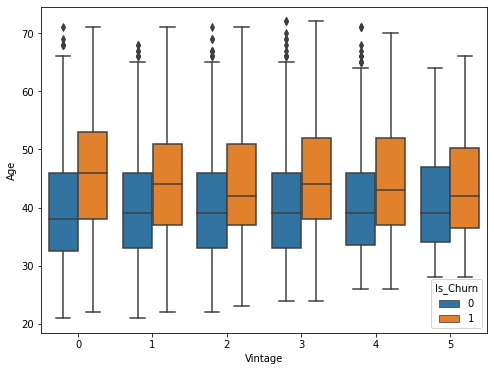

In [6]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Vintage',y='Age',hue='Is_Churn',data=train)

<AxesSubplot:xlabel='Vintage', ylabel='Balance'>

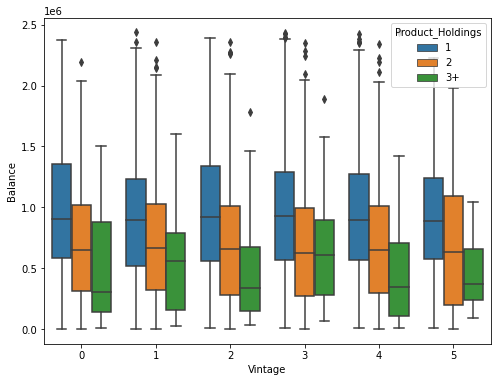

In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Vintage',y='Balance',hue='Product_Holdings',data=train)

<AxesSubplot:xlabel='Vintage', ylabel='Age'>

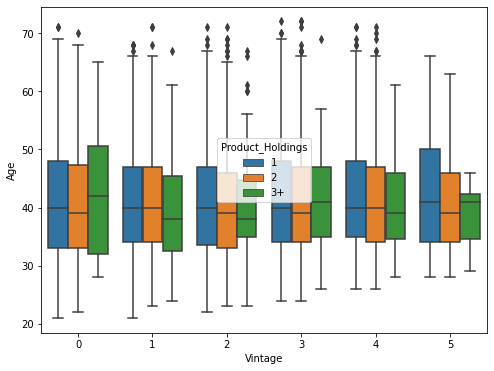

In [8]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Vintage',y='Age',hue='Product_Holdings',data=train)

<AxesSubplot:xlabel='Income', ylabel='Balance'>

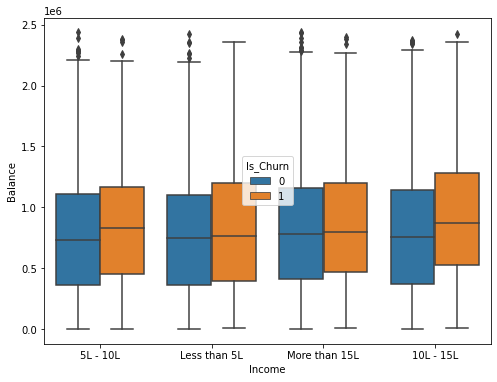

In [9]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Income',y='Balance',hue='Is_Churn',data=train)

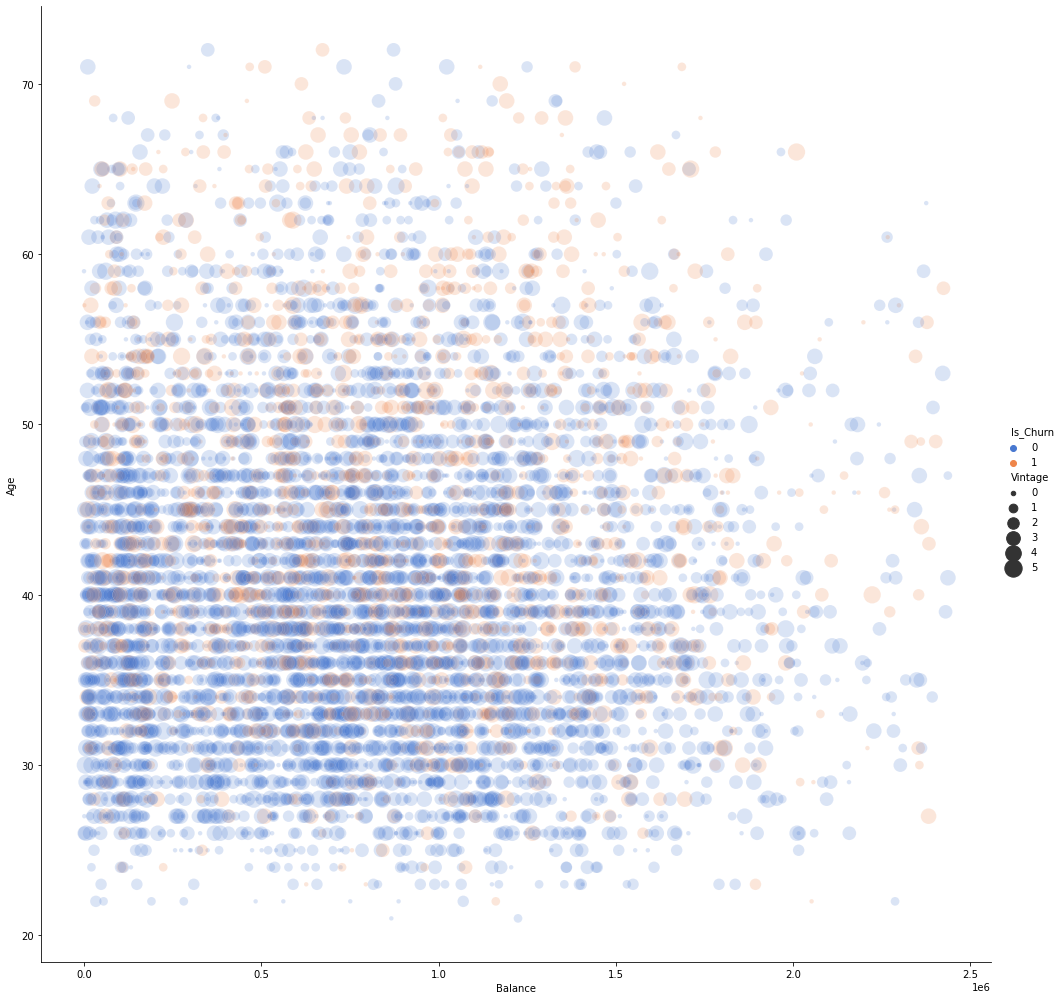

In [10]:
sns.relplot(x='Balance',y='Age',hue='Is_Churn',size='Vintage',data=train,sizes=(20,300),alpha=0.2,palette='muted',height=14)

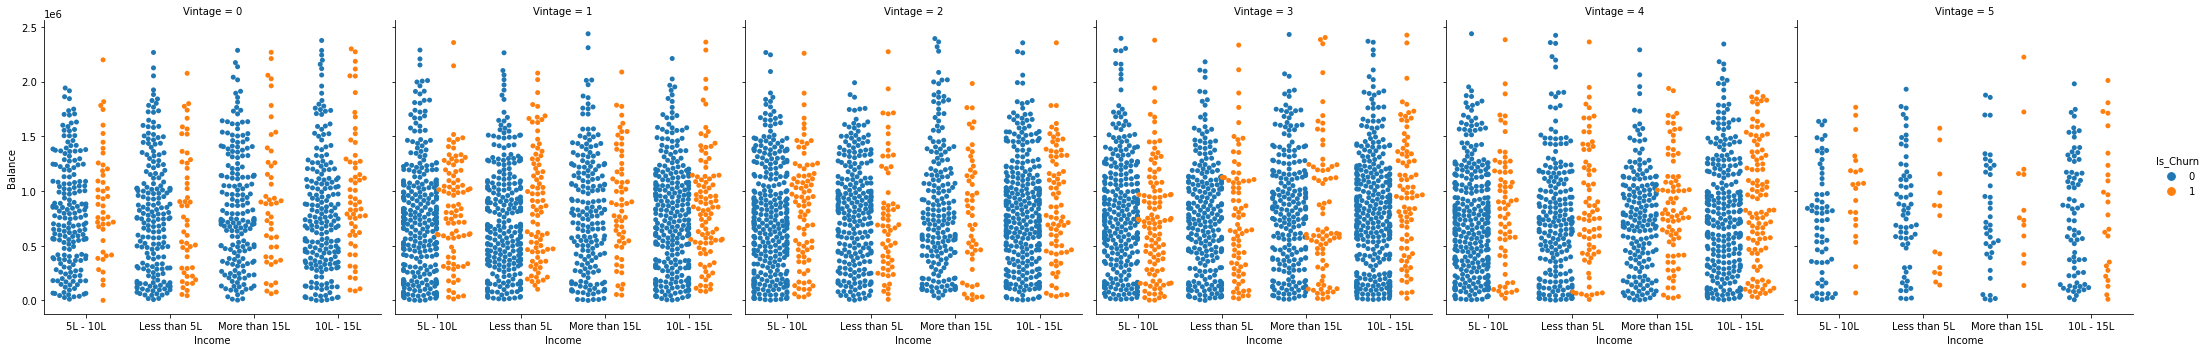

In [11]:
sns.catplot(x='Income',y='Balance',hue='Is_Churn',data=train,dodge=True,col='Vintage',kind='swarm')

<Figure size 1080x1296 with 0 Axes>

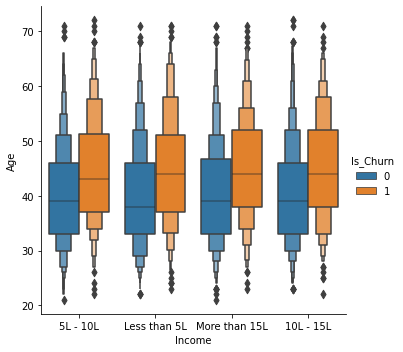

In [12]:
plt.figure(figsize=(15,18))
sns.catplot(y='Age',x='Income',data=train,hue='Is_Churn',kind='boxen')

<AxesSubplot:xlabel='Age', ylabel='Count'>

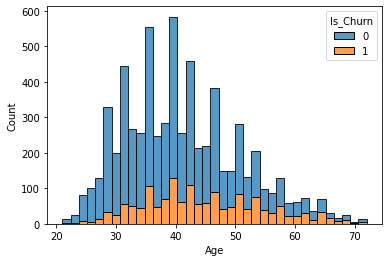

In [13]:
sns.histplot(data=train,x='Age',hue='Is_Churn',multiple='stack')

# Outlier Removal

In [14]:
#the people with age > 65 are more likely to churn churn, as observed from boxplot
train=train[((train['Is_Churn']==0) & (train['Age']<65))  |  (train['Is_Churn']==1) ]

In [15]:
train.shape

(6590, 11)

In [16]:
#the people with income less than 10lacs and balance more than 22lacs are likely to churn more as observed brom box plot
train=train[~ (((train['Is_Churn']==0) & (train['Income']=='Less than 5L') & (train['Balance']>2200000))|((train['Is_Churn']==0) & (train['Income']=='5L - 10L') & (train['Balance']>2200000)))]

In [17]:
train=train[~ ((((train['Product_Holdings']=='2') & (train['Balance']>2000000))))]

# Concating train and test data into single Dataframe for preprocessing

In [18]:
train['train_or_test']='train'
test['train_or_test']='test'
df=pd.concat([train,test])

# Feature Engineering

In [19]:
#df['Balance_gender_mean']=df.groupby(['Gender'])['Balance'].transform('mean')
#df['Balance_Credit_Category_mean']=df.groupby(['Credit_Category'])['Balance'].transform('mean')
df['Balance_Transaction_Status_mean']=df.groupby(['Transaction_Status'])['Balance'].transform('mean')
df['Balance_Transaction_Status_std']=df.groupby(['Transaction_Status'])['Balance'].transform('std')
#df['Balance_Product_Holdings_mean']=df.groupby(['Product_Holdings'])['Balance'].transform('mean')
#df['Balance_Vintage_mean']=df.groupby(['Vintage'])['Balance'].transform('mean')
df['Balance_Product_Holdings_std']=df.groupby(['Product_Holdings'])['Balance'].transform('std')
df['Balance_Vintage_std']=df.groupby(['Vintage'])['Balance'].transform('std')

In [20]:
def age_bucket(age):
    if age < 20:
        return 0
    elif age < 30:
        return 1
    elif age < 40:
        return 2
    elif age < 50:
        return 3
    elif age < 60:
        return 4
    elif age < 65:
        return 5
    else:
        return 6

In [21]:
df['Age'] = df['Age'].apply(age_bucket)

In [22]:
df['Balance_age_mean']=df.groupby(['Age'])['Balance'].transform('mean')
df['Balance_age_std']=df.groupby(['Age'])['Balance'].transform('std')

In [23]:
df['Balance_income_vintage_mean']=df.groupby(['Income','Vintage'])['Balance'].transform('mean')
df['Balance_income_vintage_std']=df.groupby(['Income','Vintage'])['Balance'].transform('std')

In [24]:
#Balance_discretizer = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')
#df['Balance_Bins'] =Balance_discretizer.fit_transform(df['Balance'].values.reshape(-1,1)).astype(int)

In [25]:
def balance_bins(balance):
    if balance < 250000:
        return 0
    elif balance < 750000:
        return 1
    elif balance < 1250000:
        return 2
    elif balance < 1750000:
        return 3
    elif balance < 2250000:
        return 4
    else:
        return 5

In [26]:
df['balance_bins'] = df['Balance'].apply(balance_bins)

In [27]:
def frequency_encoding(column_name,output_column_name,df):
    fe_pol = (df.groupby(column_name).size()) / len(df)
    df[output_column_name] = df[column_name].apply(lambda x : fe_pol[x])

# Feature Interaction

In [28]:
df['gender_CC']=df['Credit_Card'].astype('str')+'_'+df['Gender'].astype('str')
df['TS_CC']=df['Credit_Card'].astype('str')+'_'+df['Transaction_Status'].astype('str')

In [29]:
df.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,...,Balance_Transaction_Status_std,Balance_Product_Holdings_std,Balance_Vintage_std,Balance_age_mean,Balance_age_std,Balance_income_vintage_mean,Balance_income_vintage_std,balance_bins,gender_CC,TS_CC
0,84e2fcc9,2,Female,5L - 10L,563266.44,4,0,1,0,Average,...,513490.495430,525649.300254,504316.522670,803296.070201,506857.385154,758338.196050,494659.971647,1,0_Female,0_0
1,57fea15e,4,Female,Less than 5L,875572.11,2,1,1,1,Poor,...,510287.870015,525649.300254,508872.210847,811106.484732,524024.171653,815916.641889,494081.456081,2,1_Female,1_1
2,8df34ef3,2,Female,More than 15L,701607.06,2,1,2,0,Poor,...,510287.870015,464536.347197,508872.210847,803296.070201,506857.385154,826616.610526,542207.622401,1,0_Female,0_1
3,c5c0788b,3,Female,More than 15L,1393922.16,0,1,2,1,Poor,...,510287.870015,464536.347197,537289.144393,797695.805728,515551.703484,856537.856697,531180.313544,3,1_Female,1_1
4,951d69c4,2,Female,More than 15L,893146.23,1,1,1,1,Good,...,510287.870015,525649.300254,499833.832367,803296.070201,506857.385154,846471.615211,509512.043899,2,1_Female,1_1


# Feature Mapping

In [30]:
df1=df.copy()
df1['Product_Holdings'] = df1['Product_Holdings'].replace('3+', '3').astype('int')
df1['Gender'] = df1['Gender'].map({'Male': 0,'Female': 1})
df1['Credit_Category'] = df1['Credit_Category'].map({'Poor': 0,'Average': 1,'Good': 2})
df1['Income'] = df1['Income'].map({'Less than 5L': 250000,'5L - 10L': 750000,'10L - 15L':1250000,'More than 15L': 17500000})
#df1['Vintage']=df1['Vintage'].apply(lambda x: 0 if x<3 else 1)

In [31]:
df1['Income'].dtype

dtype('int64')

In [32]:
df1['over_draft']=df1['balance_bins']-df1['Income']*df1['Vintage']

In [33]:
df1.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,...,Balance_Product_Holdings_std,Balance_Vintage_std,Balance_age_mean,Balance_age_std,Balance_income_vintage_mean,Balance_income_vintage_std,balance_bins,gender_CC,TS_CC,over_draft
0,84e2fcc9,2,1,750000,563266.44,4,0,1,0,1,...,525649.300254,504316.522670,803296.070201,506857.385154,758338.196050,494659.971647,1,0_Female,0_0,-2999999
1,57fea15e,4,1,250000,875572.11,2,1,1,1,0,...,525649.300254,508872.210847,811106.484732,524024.171653,815916.641889,494081.456081,2,1_Female,1_1,-499998
2,8df34ef3,2,1,17500000,701607.06,2,1,2,0,0,...,464536.347197,508872.210847,803296.070201,506857.385154,826616.610526,542207.622401,1,0_Female,0_1,-34999999
3,c5c0788b,3,1,17500000,1393922.16,0,1,2,1,0,...,464536.347197,537289.144393,797695.805728,515551.703484,856537.856697,531180.313544,3,1_Female,1_1,3
4,951d69c4,2,1,17500000,893146.23,1,1,1,1,2,...,525649.300254,499833.832367,803296.070201,506857.385154,846471.615211,509512.043899,2,1_Female,1_1,-17499998


In [34]:
le = LabelEncoder()
for col in ['gender_CC','TS_CC']:
    df1[col]=  df1[col].astype('str')
    df1[col]= le.fit_transform(df[col])

In [35]:
corr=df1.corr()

<AxesSubplot:>

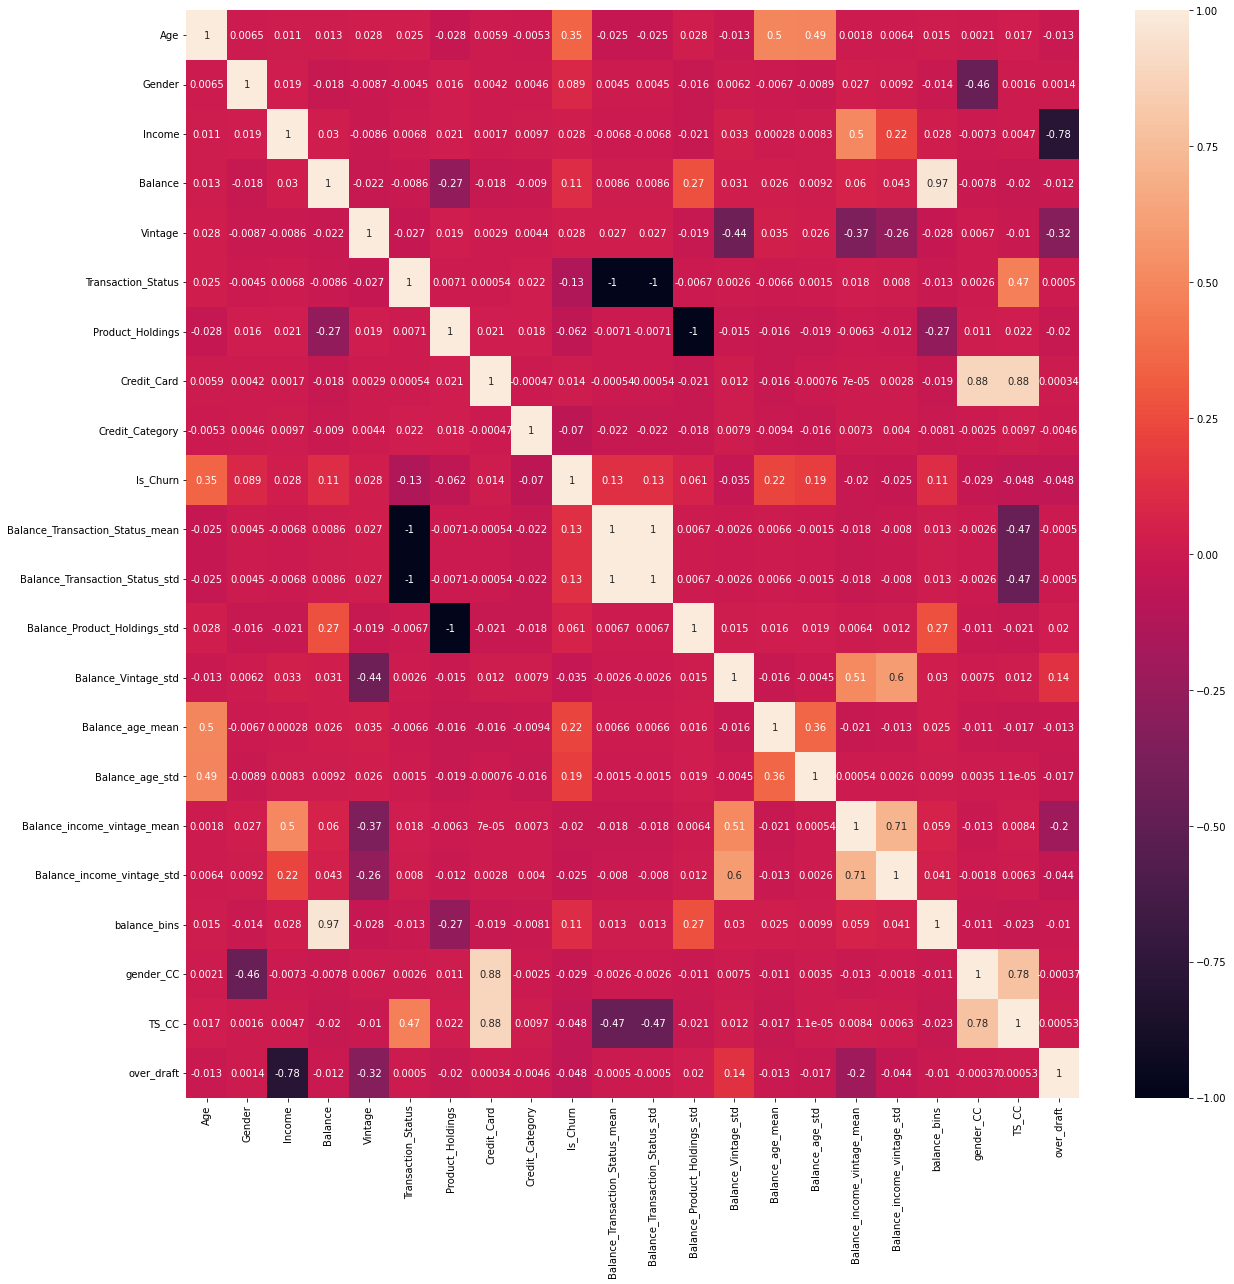

In [36]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True)

In [37]:
df_all_corr = df1.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Is_Churn']

,Feature 1,Feature 2,Correlation Coefficient
10,Is_Churn,Is_Churn,1.000000
66,Is_Churn,Age,0.346086
83,Is_Churn,Balance_age_mean,0.220435
86,Is_Churn,Balance_age_std,0.192334
91,Is_Churn,Balance_Transaction_Status_mean,0.127954
93,Is_Churn,Transaction_Status,0.127954
95,Is_Churn,Balance_Transaction_Status_std,0.127954
96,Is_Churn,Balance,0.111887
99,Is_Churn,balance_bins,0.110547
100,Is_Churn,Gender,0.088675


In [108]:
train1=df1[df1.train_or_test=='train']
test1=df1[df1.train_or_test=='test']
train1.drop('train_or_test',axis=1,inplace=True)
test1.drop('train_or_test',axis=1,inplace=True)

AttributeError: 'DataFrame' object has no attribute 'train_or_test'

In [39]:
train1.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,...,Balance_Product_Holdings_std,Balance_Vintage_std,Balance_age_mean,Balance_age_std,Balance_income_vintage_mean,Balance_income_vintage_std,balance_bins,gender_CC,TS_CC,over_draft
0,84e2fcc9,2,1,750000,563266.44,4,0,1,0,1,...,525649.300254,504316.522670,803296.070201,506857.385154,758338.196050,494659.971647,1,0,0,-2999999
1,57fea15e,4,1,250000,875572.11,2,1,1,1,0,...,525649.300254,508872.210847,811106.484732,524024.171653,815916.641889,494081.456081,2,2,3,-499998
2,8df34ef3,2,1,17500000,701607.06,2,1,2,0,0,...,464536.347197,508872.210847,803296.070201,506857.385154,826616.610526,542207.622401,1,0,1,-34999999
3,c5c0788b,3,1,17500000,1393922.16,0,1,2,1,0,...,464536.347197,537289.144393,797695.805728,515551.703484,856537.856697,531180.313544,3,2,3,3
4,951d69c4,2,1,17500000,893146.23,1,1,1,1,2,...,525649.300254,499833.832367,803296.070201,506857.385154,846471.615211,509512.043899,2,2,3,-17499998


In [40]:
target = train1['Is_Churn']

train_df = train1.drop(columns =['ID','Is_Churn'])

test_df = test1.drop(columns=['ID','Is_Churn'])

# CV LightGBM

In [41]:
def feature_importance(model, X_train):

    fI = model.feature_importances_
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 6581 rows of holdout = 2821
[100]	valid_0's binary_logloss: 0.484912	valid_0's auc: 0.765792
[200]	valid_0's binary_logloss: 0.474234	valid_0's auc: 0.77
[300]	valid_0's binary_logloss: 0.471797	valid_0's auc: 0.771086
LGB Val OOF AUC= 0.7711503147089896
####################################################################################################
[12016.56785631  1338.84191877   567.96027842  4332.46269408
   586.75616157  1468.39706086   634.69899437   154.03209922
  1315.51994984   894.70429376   527.32364237   370.36876082
   788.62558593  5639.77062057  4223.40594318  1683.60041899
  1715.05696461  1405.59558753   867.14166443   557.28826436
  2402.91372582]


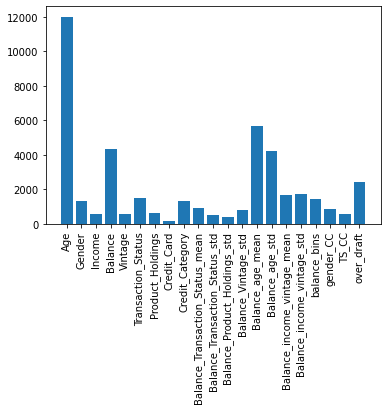

Fold 1
 rows of train = 6581 rows of holdout = 2821
[100]	valid_0's binary_logloss: 0.479957	valid_0's auc: 0.779923
[200]	valid_0's binary_logloss: 0.468478	valid_0's auc: 0.779898
LGB Val OOF AUC= 0.7800765102474727
####################################################################################################
Fold 2
 rows of train = 6581 rows of holdout = 2821
[100]	valid_0's binary_logloss: 0.489575	valid_0's auc: 0.753211
[200]	valid_0's binary_logloss: 0.482889	valid_0's auc: 0.754255
LGB Val OOF AUC= 0.7547703638715662
####################################################################################################
Fold 3
 rows of train = 6581 rows of holdout = 2821
[100]	valid_0's binary_logloss: 0.482611	valid_0's auc: 0.771286
[200]	valid_0's binary_logloss: 0.472167	valid_0's auc: 0.773659
[300]	valid_0's binary_logloss: 0.470987	valid_0's auc: 0.773653
LGB Val OOF AUC= 0.7739463374407533
###############################################################################

In [42]:
%%time
##LightGBM

cat_features = ['Age', 'Gender', 'Income', 'Vintage','Balance_Bins', 'gender_CC', 'TS_CC',
                'Transaction_Status', 'Product_Holdings', 'Credit_Card','Credit_Category' ]

cont_features = ['Balance']

probs_lgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])

    X_train_cv,y_train_cv = train_df.copy(), target.copy()

    sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.3,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = lgb.LGBMClassifier(boosting_type='gbdt',
                                 n_estimators=10000,
                                 max_depth=10,
                                 learning_rate=0.02,
                                 subsample=0.9,
                                 colsample_bytree=0.4,
                                 objective ='binary',
                                 random_state = 1,
                                 importance_type='gain',
                                 reg_alpha=2,
                                 reg_lambda=2
                                 #cat_features=cat_features
                                )        
        
        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['binary_logloss','auc'],
                    early_stopping_rounds=100)
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_lgb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        avg_loss.append(clf.best_score_['valid_0']['binary_logloss'])

        print ('LGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            feature_importance(clf,X_train_cv)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

# CV XGBOOST

  0%|          | 0/1 [00:00<?, ?it/s]

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 6581 rows of holdout = 2821
[0]	validation_0-auc:0.72035	validation_0-logloss:0.67937
[100]	validation_0-auc:0.76859	validation_0-logloss:0.47578
[200]	validation_0-auc:0.77033	validation_0-logloss:0.47281
[238]	validation_0-auc:0.76960	validation_0-logloss:0.47325
XGB Val OOF AUC= 0.7706655390362975
####################################################################################################
[0.17500323 0.05089124 0.01932939 0.04421819 0.02480854 0.04135704
 0.02410182 0.02221922 0.03159946 0.04314503 0.048553   0.02723797
 0.02404958 0.12021802 0.13896854 0.02778246 0.02814797 0.02843552
 0.02440877 0.02763046 0.02789458]


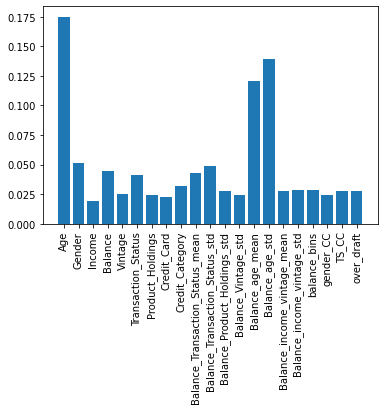

Fold 1
 rows of train = 6581 rows of holdout = 2821
[0]	validation_0-auc:0.74445	validation_0-logloss:0.67931
[100]	validation_0-auc:0.77987	validation_0-logloss:0.46939
[200]	validation_0-auc:0.77928	validation_0-logloss:0.46690
[211]	validation_0-auc:0.77939	validation_0-logloss:0.46692
XGB Val OOF AUC= 0.780401560239964
####################################################################################################
Fold 2
 rows of train = 6581 rows of holdout = 2821
[0]	validation_0-auc:0.72078	validation_0-logloss:0.67936
[100]	validation_0-auc:0.75281	validation_0-logloss:0.48336
[173]	validation_0-auc:0.75124	validation_0-logloss:0.48522
XGB Val OOF AUC= 0.7533878310767552
####################################################################################################
Fold 3
 rows of train = 6581 rows of holdout = 2821
[0]	validation_0-auc:0.73284	validation_0-logloss:0.67923
[100]	validation_0-auc:0.77252	validation_0-logloss:0.47353
[189]	validation_0-auc:0.77180	valida

In [43]:
%%time

##XGBM

probs_xgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.3 ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = xgb.XGBClassifier(n_estimators=1000,
                                max_depth=6,
                                learning_rate=0.04,
                                subsample=0.9,
                                colsample_bytree=0.35,
                                objective = 'binary:logistic',
                                random_state = 1
                               )        


        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['auc','logloss'],
                    early_stopping_rounds=50)
        
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_xgb +=clf.predict_proba(test_df)[:,1]

        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)
        
        avg_loss.append(clf.best_score)

        print ('XGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            
            feature_importance(clf,X_train_cv)
            
print("Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

# CV CatBoost

  0%|          | 0/1 [00:00<?, ?it/s]

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 6581 rows of holdout = 2821
0:	learn: 0.6830227	test: 0.6834243	best: 0.6834243 (0)	total: 233ms	remaining: 38m 54s
100:	learn: 0.4444089	test: 0.4846449	best: 0.4846449 (100)	total: 4.16s	remaining: 6m 48s
200:	learn: 0.4154057	test: 0.4778769	best: 0.4778769 (200)	total: 8.15s	remaining: 6m 37s
300:	learn: 0.3957529	test: 0.4760320	best: 0.4760063 (296)	total: 12.2s	remaining: 6m 34s
400:	learn: 0.3788559	test: 0.4751103	best: 0.4751034 (397)	total: 16.8s	remaining: 6m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4748869651
bestIteration = 426

Shrink model to first 427 iterations.
CatBoost Val OOF AUC= 0.7666944622283346
[ 6.83827202  4.42160882  4.4387887  10.35601838  4.74445985  2.1492097
  2.72613882  1.38737845  7.77669435  1.9682479   2.03357728  2.31332838
  2.31947671 10.89911304 11.55431723  3.78526016  4.06005668  

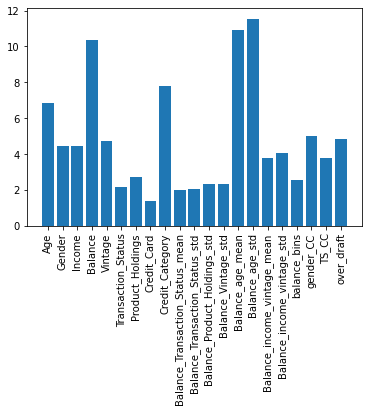

####################################################################################################
Fold 1
 rows of train = 6581 rows of holdout = 2821
0:	learn: 0.6833492	test: 0.6836109	best: 0.6836109 (0)	total: 31.3ms	remaining: 5m 13s
100:	learn: 0.4482919	test: 0.4755550	best: 0.4755550 (100)	total: 3.6s	remaining: 5m 52s
200:	learn: 0.4192954	test: 0.4668404	best: 0.4668404 (200)	total: 7.28s	remaining: 5m 54s
300:	learn: 0.4035612	test: 0.4652245	best: 0.4652245 (300)	total: 11.1s	remaining: 5m 56s
400:	learn: 0.3876322	test: 0.4645516	best: 0.4644357 (374)	total: 15.1s	remaining: 6m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4643490216
bestIteration = 436

Shrink model to first 437 iterations.
CatBoost Val OOF AUC= 0.784172403617902
####################################################################################################
Fold 2
 rows of train = 6581 rows of holdout = 2821
0:	learn: 0.6827936	test: 0.6833542	best: 0.6833542 (0)	total: 45.1ms

In [44]:
%%time

##CatBoost

cat_features = ['Age', 'Gender', 'Income', 'Vintage', 'gender_CC', 'TS_CC','balance_bins',
                'Transaction_Status', 'Product_Holdings', 'Credit_Card','Credit_Category' ]

cont_features = ['Balance']

probs_cb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.3 ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = CatBoostClassifier(iterations=10000,
                                learning_rate=0.02,
                                random_strength=0.1,
                                depth=8,
                                loss_function='Logloss',
                                eval_metric='Logloss',
                                leaf_estimation_method='Newton',
                                random_state = 1,
                                cat_features =cat_features,
                                subsample = 0.9,
                                rsm = 0.8
                                )    

        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                   early_stopping_rounds=50,verbose = 100)

        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_cb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        print ('CatBoost Val OOF AUC=',roc)

        avg_loss.append(clf.best_score_['validation']['Logloss'])

        if i==0:
            
            feature_importance(clf,X_train_cv)

        print('#'*100)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

# NN Model

In [45]:
X = train1.drop(['Is_Churn','ID'],axis=1)       # Features - All columns but last
y = train1['Is_Churn']         # Target - Last Column

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [48]:
import keras
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.layers import Dropout
from keras import regularizers

  # create model
model = Sequential()
model.add(Dense(900, input_dim= 21, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

early_stopping = keras.callbacks.EarlyStopping( patience = 12, min_delta = 0.001,
                                               restore_best_weights =True )
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10,validation_data=(X_test, y_test),verbose=1)
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/50
753/753 [==============================] - 4s 4ms/step - loss: 0.5957 - binary_accuracy: 0.7200 - val_loss: 0.5175 - val_binary_accuracy: 0.7640
Epoch 2/50
753/753 [==============================] - 3s 3ms/step - loss: 0.5293 - binary_accuracy: 0.7538 - val_loss: 0.4952 - val_binary_accuracy: 0.7560
Epoch 3/50
753/753 [==============================] - 3s 4ms/step - loss: 0.5113 - binary_accuracy: 0.7625 - val_loss: 0.5017 - val_binary_accuracy: 0.7714
Epoch 4/50
753/753 [==============================] - 3s 4ms/step - loss: 0.5034 - binary_accuracy: 0.7605 - val_loss: 0.5004 - val_binary_accuracy: 0.7671
Epoch 5/50
753/753 [==============================] - 3s 4ms/step - loss: 0.5060 - binary_accuracy: 0.7643 - val_loss: 0.4967 - val_binary_accuracy: 0.7608
Epoch 6/50
753/753 [==============================] - 3s 4ms/step - loss: 0.5006 - binary_accuracy: 0.7651 - val_loss: 0.4884 - val_binary_accuracy: 0.7709
Epoch 7/50
753/753 [==============================] - 3s 4ms/ste

In [49]:
test2 = test1.drop(['ID','Is_Churn'],axis=1)

In [50]:
test2=sc.transform(test2)

In [51]:
p4=model.predict(test2)
p4=p4.flatten()

In [52]:
p1 =probs_lgb/5

p2 = probs_cb/5

p3 = probs_xgb/5

In [53]:
p1,p2,p3,p4

(array([0.47165006, 0.18814799, 0.07323721, ..., 0.55606987, 0.37792674,
        0.49656705]),
 array([0.50189768, 0.14750221, 0.05977555, ..., 0.63207917, 0.3713961 ,
        0.57974238]),
 array([0.50039759, 0.19594771, 0.04870141, ..., 0.63788285, 0.38145029,
        0.5536301 ]),
 array([0.38337553, 0.19563597, 0.00868583, ..., 0.7163055 , 0.3563826 ,
        0.89461195], dtype=float32))

In [102]:
pred =p4*0.6+0.4*p2

In [103]:
out=pd.DataFrame(pred,columns=['Is_Churn'])

In [104]:
out1=out.copy()
out1['Is_Churn']=out1['Is_Churn'].apply(lambda x: 0 if x<0.50 else 1)

In [105]:
final1=pd.concat([test1['ID'],out1['Is_Churn']],axis=1)

In [106]:
final1['Is_Churn'].value_counts()

0    2395
1     456
Name: Is_Churn, dtype: int64

In [107]:
final1.to_csv('NN_1.csv',index=False)